<a href="https://colab.research.google.com/github/firesworder/Ml-Staff/blob/main/cats_and_dogs%2C_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
MODEL_SAVED = True
OPT_MODEL_SAVED = True

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
path_to_drive = '/content/drive/MyDrive'
path_to_model = os.path.join(path_to_drive, 'saved_models', 'model_cats_and_dogs')
path_to_opt_model = os.path.join(path_to_drive, 'saved_models', 'opt_model_cats_and_dogs')

Mounted at /content/drive


In [ ]:
#drive.flush_and_unmount()

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

rm: cannot remove '/root/.kaggle': No such file or directory
ref                                                                title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
victorsoeiro/netflix-tv-shows-and-movies                           Netflix TV Shows and Movies                           2MB  2022-05-15 00:01:23          15938        461  1.0              
ruchi798/data-science-job-salaries                                 Data Science Job Salaries                             7KB  2022-06-15 08:59:12           5078        177  1.0              
zusmani/petrolgas-prices-worldwide                                 Petrol/Gas Prices Worldwide                          10KB  2022-06-24 01:25:33           2017         95  1.

In [ ]:
!kaggle datasets download -d tongpython/cat-and-dog

 97% 212M/218M [00:02<00:00, 107MB/s] 
100% 218M/218M [00:02<00:00, 78.2MB/s]


In [ ]:
!unzip cat-and-dog.zip

In [ ]:
!mkdir cats_and_dogs
!mv ./training_set/training_set/ ./cats_and_dogs
!mv ./test_set/test_set/ ./cats_and_dogs
!rmdir ./test_set/
!rmdir ./training_set/

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from matplotlib import pyplot as plt

In [ ]:
DIR_PATH = './cats_and_dogs/'

train_dir = os.path.join(DIR_PATH, 'training_set')
test_dir = os.path.join(DIR_PATH, 'test_set')

In [ ]:
# количество изображений в датасете
for dir_name in ['training_set', 'test_set']:
    for class_name in ['cats', 'dogs']:
        path, _, files = list(os.walk(os.path.join(DIR_PATH, dir_name, class_name)))[0]
        print(f'{dir_name}: {class_name} - {len(files)}')

training_set: cats - 4001
training_set: dogs - 4006
test_set: cats - 1012
test_set: dogs - 1013


dog
(499, 421, 3)
cat
(283, 264, 3)


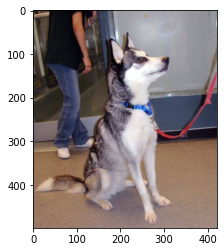

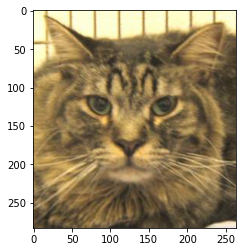

In [ ]:
images_example = {'dog': 'test_set/dogs/dog.4001.jpg', 'cat': 'test_set/cats/cat.4246.jpg'}

for animal in images_example:
    image = plt.imread(os.path.join(DIR_PATH, images_example[animal]))
    plt.figure()
    print(animal)
    plt.imshow(image)
    print(image.shape)

Картинки отличаются размерами, т.е. нужен препроцессинг(пусть я его все равно собирался делать)

In [ ]:
BATCH_SIZE = 150
IMAGE_SIZE = 128

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_data_gen = train_gen.flow_from_directory(
    train_dir, 
    target_size=(IMAGE_SIZE, IMAGE_SIZE), 
    class_mode='binary',
    batch_size=32,
    shuffle=True,
)

test_data_gen = test_gen.flow_from_directory(
    test_dir, 
    target_size=(IMAGE_SIZE, IMAGE_SIZE), 
    class_mode='binary',
    batch_size=32,
    shuffle=False,
)

train_data_gen.class_indices

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


{'cats': 0, 'dogs': 1}

In [ ]:
from tensorflow.keras.models import Sequential

# Объявление модели
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)),
    Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(),
    
    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile('Adam', 'binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                    

In [ ]:
if MODEL_SAVED:
  model = tf.keras.models.load_model(path_to_model)
else:
  history = model.fit(x=train_data_gen, epochs=20, validation_data=test_data_gen)
  model.save(path_to_model)

Что то точность выше 75% не получается.  
И модель всегда переобучается. Хоть 3 слоя по 2 Conv, хоть 1. Хоть 128 на Dense, хоть 16.  
Хрень какая то.

Да и обучается довольно долго.

Чтобы справиться с переобучением - применяю оба известных мне метода - аугментацию и упрощение(скорее оптимизация) модели.

Упрощение модели:  
заменяю flatten на Global average pooling + flatten

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D

# Объявление модели
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)),
    Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(),
    
    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(),

    Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(),
    
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                  

Количество параметров для Dense слоя - уменьшилось в 1к+ раз!

Теперь аугментация.  
Средствами Керас изменяю ImageDataGenerator для train сета - добавляю растяжения\смещения\повоорт изображений и т.п., для усложнения и "увеличения" датасета.

In [ ]:
train_gen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2, 
    fill_mode='nearest', # чем заполнять пустоты
    horizontal_flip=True,
    )

train_data_gen_aug = train_gen_aug.flow_from_directory(
    train_dir, 
    target_size=(IMAGE_SIZE, IMAGE_SIZE), 
    class_mode='binary',
    batch_size=32,
    shuffle=True,
)

Found 8005 images belonging to 2 classes.


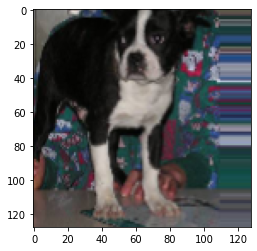

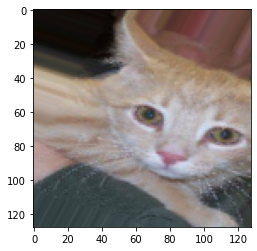

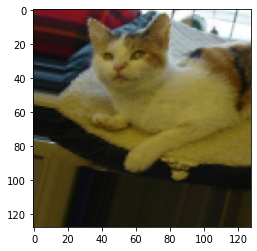

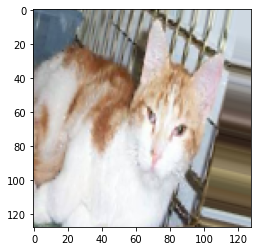

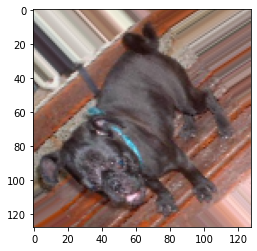

In [ ]:
pics, _ = next(train_data_gen_aug)
for pic in pics[:5]:
  plt.figure()
  plt.imshow(pic)

In [ ]:
if OPT_MODEL_SAVED:
  model = tf.keras.models.load_model(path_to_opt_model)
else:
  history = model.fit(x=train_data_gen_aug, epochs=100, validation_data=test_data_gen)
  model.save(path_to_opt_model)
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.legend()

В текущем виде - модель за 80 эпох обучилась на точность 84% примерно.(с учетом переобучения)  
Аугментация и замена флаттен привела к тому, что и точность поднялась с 75% до 84%, и к тому, что модель дольше не ПЕРЕобучалась.
___________

Надо бы еще 2 слоя добавить, для глубины и эпох ставить сразу 100.  
А еще я аугментацию забыл использовать х_х
_____
Upd. Это лучшее что я смог получить. Больше слоев не обучается.  
Переобучения почти нет  
Каеф крч

## Испытание модели

In [ ]:
# объявлю генератор, чтобы погонять модель(и вручную не писать демо список)
demo_gen = test_gen.flow_from_directory(
    test_dir, 
    target_size=(IMAGE_SIZE, IMAGE_SIZE), 
    class_mode='binary',
    batch_size=16,
    shuffle=True,
)

Found 2023 images belonging to 2 classes.


In [ ]:
def show_cats_and_dogs(images, labels, pred_labels=None):
  names = {0: 'Кот', 1: 'Собака'}
  plt.figure(figsize=(10, 10))
  for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
    if pred_labels is not None:
      title_obj = plt.title(f'Правда: {names[labels[i]]}. \n Предсказание: {names[pred_labels[i]]}')
      if labels[i] != pred_labels[i]:
        plt.setp(title_obj, color='r')
    else:
      plt.title(f'Правда: {names[labels[i]]}.')

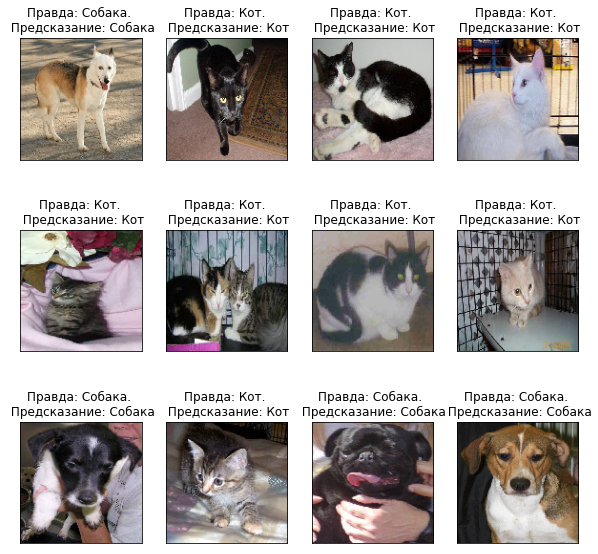

In [ ]:
demo_X, demo_y = next(demo_gen)
preds = model.predict(demo_X)
preds = [0 if x <= 0.5 else 1 for x in preds.flatten()]
show_cats_and_dogs(demo_X, demo_y, preds)